### Initial Setup

In [1]:
# Install
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Import
import os 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile 
from skimage import io 
from torch.utils.data import Dataset
import torch 
import pandas as pd 
from torchvision import transforms
import copy
from sklearn.metrics import mean_squared_error

In [3]:
# System Check
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [4]:
# Find GPU
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
# Reserve GPU
if IN_CADE:
    define_gpu_to_use()

Chosen GPU: 0


### Load and Visualize Dataset

In [6]:
# Opens zip file and places data in datsets folder
def open_zip(filename):
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()

In [7]:
# Return indexes to split data by for train, val, and test
# Splits are 70% train, 10% val, 20% test
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [8]:
# Dataset class for Truss (Bracket/Beam) dataset
class TrussDataset(Dataset):
    def __init__(self, csv_file, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        # Get the split
        all_attributes_frame = pd.read_csv(root_dir + csv_file)
        ids = get_split(pd.unique(all_attributes_frame['ID']), split)
        self.attributes_frame = all_attributes_frame[all_attributes_frame['ID'].isin(ids)]
              
    def __len__(self):
        return len(self.attributes_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.attributes_frame.iloc[idx, 1])
        image = io.imread(image_name)
        image = image.astype(np.float32)
        image = image[:,:,:3]
        image = image/255
        image = np.swapaxes(image, 0, 1)
        image = np.swapaxes(image, 0, 2)
        attributes = self.attributes_frame.iloc[idx, 2:].values
        attributes = attributes.astype('float')
        attribute_names = self.attributes_frame.columns[2:].values
        return torch.FloatTensor(image), torch.FloatTensor(attributes), list(attribute_names)

In [9]:
# Open zip of dataset
open_zip('trussData.zip')

In [10]:
# Create train, val, and test datasets
train_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/')
val_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='val')
test_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='test')

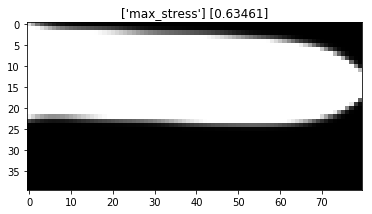

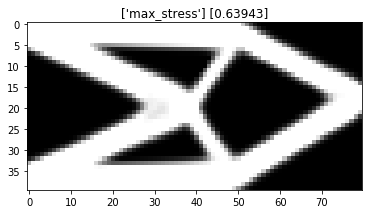

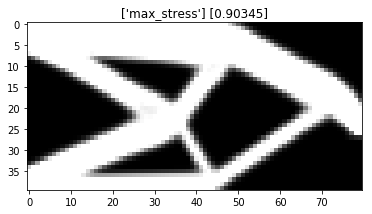

In [11]:
# Visualing a few cases of the training set
for batch_idx, (image, attribute, name) in enumerate(train_dataset):
    if batch_idx%250 == 0: 
        plt.figure()
        plt.title(str(name) + ' ' + str(attribute.cpu().numpy()))
        plt.imshow(image[:,:,:].permute([1, 2, 0]).cpu().numpy())

In [12]:
# Calculates L2 for images and MSE for regression - want both close to 0
def get_score_model(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        distances = []
        mse = []
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, logvar, reg = model(image)
            # Reconstruction Score
            euclidean_dist = torch.pow(torch.sum(torch.pow((image - recon), 2)), 0.5)
            distances.append(euclidean_dist.cpu().numpy())
            # Regression Score
            y_true = attribute.cpu().numpy()
            y_pred = reg.cpu().numpy()         
            mse.append(mean_squared_error(y_true, y_pred))
    
    return np.mean(distances), np.mean(mse)

In [13]:
# Classes to create VAE, ability to change kernel_size of filters for convolution layers
# and the latent representation dim
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        padding = int((kernel_size - 1) / 2)
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.batch = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

class TransBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransBlock, self).__init__()
        self.convT = torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.convT(x)
        return x

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 32, 5, 10) # see if there is a way to not have this hardcoded

In [14]:
# VAE with Regression - The reconstruction and regression are done from the
# latent variables calculated from the reparametrization (distribution)
class VAE_REG(torch.nn.Module):
    def __init__(self, kernel_size, z_dim):
        super(VAE_REG, self).__init__()
        self.encoder = torch.nn.Sequential(
        ConvBlock(in_channels=3, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=8, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=16, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        Flatten()) 
        
        self.mu = torch.nn.Linear(1600, z_dim)
        self.logvar = torch.nn.Linear(1600, z_dim)
        self.fc = torch.nn.Linear(z_dim, 1600)
        
        self.decoder = torch.nn.Sequential(
        UnFlatten(),
        TransBlock(in_channels=32, out_channels=32),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=16, kernel_size=kernel_size),
        TransBlock(in_channels=16, out_channels=16),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=8, kernel_size=kernel_size),
        TransBlock(in_channels=8, out_channels=8),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=3, kernel_size=kernel_size))
        
        self.regression = torch.nn.Sequential(
            torch.nn.Linear(in_features=z_dim, out_features=4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=4, out_features=1))
            
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.FloatTensor(mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, x):
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparametrize(mu, logvar)
        return z, mu, logvar
    
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
    
    def forward(self, x):
        x = self.encoder(x)
        z, mu, logvar = self.bottleneck(x) # z is latent representation
        x = self.fc(z)
        x = torch.sigmoid(self.decoder(x)) # VAE output
        r = self.regression(z) # Regression output
        return x, mu, logvar, r

In [15]:
# Loss function for this task, combines reconstruction and KL for the image task and the MSELoss
# for the regression task
def loss_function(reconstruction, image, mu, logvar, attributes, r, batch_size):
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(reconstruction, image)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /=  batch_size * image.shape[1] * image.shape[2] * image.shape[3]
    reg_loss =  torch.nn.MSELoss()
    return reconstruction_loss, kl_loss, reg_loss(attributes, r)

In [16]:
# VAE conv kernel size = 5 z_dim=4
BATCH_SIZE = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_loader_score = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#instantiate your model here:
model = VAE_REG(kernel_size=5, z_dim=4)
model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

train_recon_scores = []
train_r2_scores = []
val_recon_scores = []
val_r2_scores = []
target_score = 35.5 # Want score to be less than this
best_score = 50
best_model = copy.deepcopy(model)

print('Starting Training!')
for epoch in range(n_epochs):
    print('\nEpoch: ' + str(epoch))
    scheduler.step()
    
    model.train()
    
    total_losses = []
    reconstruction_losses = []
    kl_losses = []
    reg_losses = []
    for image, attribute, name in train_loader:
        optimizer.zero_grad()
        image = image.cuda()
        attribute = attribute.cuda()
        recon, mu, logvar, reg = model(image)
        reconstruction_loss, kl_loss, reg_loss = loss_function(recon, image, mu, logvar, attribute, reg, BATCH_SIZE)
        loss = reconstruction_loss + kl_loss + reg_loss
        loss.backward()
        optimizer.step()
        
        total_losses.append(loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        kl_losses.append(kl_loss.item())
        reg_losses.append(reg_loss.item())
        
    print('Total Loss: ' + str(np.mean(total_losses)))
    print('Reconstruction Loss: ' + str(np.mean(reconstruction_losses)))
    print('KL Loss: ' + str(np.mean(kl_losses)))
    print('Regression Loss: ' + str(np.mean(reg_losses)))
    
    # Get training data accuracy
    train_recon_score, train_r2 = get_score_model(model, train_loader_score)
    print('Trainig Reconstruction Score: ' + str(train_recon_score))
    print('Training MSE Score: ' + str(train_r2))
    train_recon_scores.append(train_recon_score)
    train_r2_scores.append(train_r2)
    
    # Get validation data accuracy
    val_recon_score, val_r2 = get_score_model(model, val_loader)
    print('Validation Reconstruction Score: ' + str(val_recon_score))
    print('Validation MSE Score: ' + str(val_r2))
    val_recon_scores.append(val_recon_score)
    val_r2_scores.append(val_r2)
    
    # Save Best Model - Based on Reconstruction Score
    if val_recon_score < target_score and val_recon_score < best_score:
        best_score = val_recon_score
        best_model = copy.deepcopy(model)
        print('New Best Model Saved!')

Starting Training!

Epoch: 0
Total Loss: 0.6963798701763153
Reconstruction Loss: 0.6695207604340144
KL Loss: 0.002726600487949327
Regression Loss: 0.024132512230426072
Trainig Reconstruction Score: 44.025875
Training MSE Score: 0.0062045534
Validation Reconstruction Score: 44.14707
Validation MSE Score: 0.005285178

Epoch: 1
Total Loss: 0.6189386572156633
Reconstruction Loss: 0.6105848474161966
KL Loss: 0.0020857408326784414
Regression Loss: 0.006268073493681316
Trainig Reconstruction Score: 40.76151
Training MSE Score: 0.006267627
Validation Reconstruction Score: 40.606785
Validation MSE Score: 0.0054559764

Epoch: 2
Total Loss: 0.5733882699693952
Reconstruction Loss: 0.5654462431158338
KL Loss: 0.0017602531289282655
Regression Loss: 0.006181772515576865
Trainig Reconstruction Score: 39.073353
Training MSE Score: 0.006310437
Validation Reconstruction Score: 38.975952
Validation MSE Score: 0.005183201

Epoch: 3
Total Loss: 0.5409930808203561
Reconstruction Loss: 0.5331189683505467
KL L

Trainig Reconstruction Score: 33.697906
Training MSE Score: 0.0051753833
Validation Reconstruction Score: 33.956207
Validation MSE Score: 0.0043062824
New Best Model Saved!

Epoch: 27
Total Loss: 0.42929523927824836
Reconstruction Loss: 0.42205147445201874
KL Loss: 0.0020108805004773397
Regression Loss: 0.005232884576876781
Trainig Reconstruction Score: 33.939728
Training MSE Score: 0.005191516
Validation Reconstruction Score: 34.168636
Validation MSE Score: 0.004227128

Epoch: 28
Total Loss: 0.4285050609282085
Reconstruction Loss: 0.42127123177051545
KL Loss: 0.0020054532431199082
Regression Loss: 0.005228376029325383
Trainig Reconstruction Score: 33.919224
Training MSE Score: 0.005151354
Validation Reconstruction Score: 34.12735
Validation MSE Score: 0.004296367

Epoch: 29
Total Loss: 0.4277671613863536
Reconstruction Loss: 0.42046718512262615
KL Loss: 0.0020155936313260877
Regression Loss: 0.005284381850755641
Trainig Reconstruction Score: 33.75329
Training MSE Score: 0.005218232
Va

Total Loss: 0.41837700988565174
Reconstruction Loss: 0.4116450220346451
KL Loss: 0.0020326738811231085
Regression Loss: 0.004699313780292869
Trainig Reconstruction Score: 33.3817
Training MSE Score: 0.0047371387
Validation Reconstruction Score: 33.724194
Validation MSE Score: 0.0047004228

Epoch: 54
Total Loss: 0.4177465796470642
Reconstruction Loss: 0.411008962563106
KL Loss: 0.0020318214083090425
Regression Loss: 0.004705795058647969
Trainig Reconstruction Score: 33.46976
Training MSE Score: 0.0046932134
Validation Reconstruction Score: 33.78771
Validation MSE Score: 0.004048074

Epoch: 55
Total Loss: 0.41725553018706185
Reconstruction Loss: 0.41059176666396
KL Loss: 0.0020434459421916733
Regression Loss: 0.004620317600867046
Trainig Reconstruction Score: 33.354916
Training MSE Score: 0.0045528035
Validation Reconstruction Score: 33.701706
Validation MSE Score: 0.004208981

Epoch: 56
Total Loss: 0.4166246439729418
Reconstruction Loss: 0.40994134843349456
KL Loss: 0.002042791485187730

Total Loss: 0.41283019525664194
Reconstruction Loss: 0.40629190121378217
KL Loss: 0.002048444252328149
Regression Loss: 0.004489846652307149
Trainig Reconstruction Score: 33.187904
Training MSE Score: 0.004432231
Validation Reconstruction Score: 33.524693
Validation MSE Score: 0.003992775
New Best Model Saved!

Epoch: 81
Total Loss: 0.4124845636742456
Reconstruction Loss: 0.405915390593665
KL Loss: 0.0020416504104754755
Regression Loss: 0.004527523870014452
Trainig Reconstruction Score: 33.238426
Training MSE Score: 0.004370865
Validation Reconstruction Score: 33.59685
Validation MSE Score: 0.0040384512

Epoch: 82
Total Loss: 0.4120586416551045
Reconstruction Loss: 0.4056767633983067
KL Loss: 0.002032379659691027
Regression Loss: 0.004349497654142657
Trainig Reconstruction Score: 33.21328
Training MSE Score: 0.0045566093
Validation Reconstruction Score: 33.61347
Validation MSE Score: 0.0039068144

Epoch: 83
Total Loss: 0.4123204384531294
Reconstruction Loss: 0.4057179514850889
KL Loss:

Total Loss: 0.4103433979409082
Reconstruction Loss: 0.4040011261190687
KL Loss: 0.0020179150526278785
Regression Loss: 0.004324356968780713
Trainig Reconstruction Score: 33.179436
Training MSE Score: 0.004277817
Validation Reconstruction Score: 33.552525
Validation MSE Score: 0.0038880804

Epoch: 108
Total Loss: 0.4098201879433223
Reconstruction Loss: 0.4034826712948935
KL Loss: 0.002011049345933965
Regression Loss: 0.0043264665062971676
Trainig Reconstruction Score: 33.153896
Training MSE Score: 0.004277263
Validation Reconstruction Score: 33.553413
Validation MSE Score: 0.0038529357

Epoch: 109
Total Loss: 0.4097253552504948
Reconstruction Loss: 0.4033759402377265
KL Loss: 0.0020132895076780447
Regression Loss: 0.004336125646451754
Trainig Reconstruction Score: 33.167404
Training MSE Score: 0.0042379303
Validation Reconstruction Score: 33.564125
Validation MSE Score: 0.0039731874

Epoch: 110
Total Loss: 0.40981734693050387
Reconstruction Loss: 0.4034708103963307
KL Loss: 0.0020283031

Trainig Reconstruction Score: 33.131115
Training MSE Score: 0.0041883797
Validation Reconstruction Score: 33.57948
Validation MSE Score: 0.0043254266

Epoch: 135
Total Loss: 0.40837091718401225
Reconstruction Loss: 0.4021519826991217
KL Loss: 0.0020242470798880925
Regression Loss: 0.00419468801036211
Trainig Reconstruction Score: 33.13689
Training MSE Score: 0.0042550843
Validation Reconstruction Score: 33.530617
Validation MSE Score: 0.0044952612

Epoch: 136
Total Loss: 0.4086034736463002
Reconstruction Loss: 0.40237214054380144
KL Loss: 0.002014530707882451
Regression Loss: 0.004216803934624685
Trainig Reconstruction Score: 33.120693
Training MSE Score: 0.0041936035
Validation Reconstruction Score: 33.545162
Validation MSE Score: 0.0037520956

Epoch: 137
Total Loss: 0.40838341670376915
Reconstruction Loss: 0.40218024381569456
KL Loss: 0.0020062255157556916
Regression Loss: 0.004196947184391319
Trainig Reconstruction Score: 33.093006
Training MSE Score: 0.004085581
Validation Reconstr

Trainig Reconstruction Score: 32.93244
Training MSE Score: 0.0039930637
Validation Reconstruction Score: 33.398888
Validation MSE Score: 0.0039818864

Epoch: 162
Total Loss: 0.40425444415637424
Reconstruction Loss: 0.39826351404190063
KL Loss: 0.001999504370282271
Regression Loss: 0.003991426307974117
Trainig Reconstruction Score: 32.927803
Training MSE Score: 0.003990174
Validation Reconstruction Score: 33.367496
Validation MSE Score: 0.003976251
New Best Model Saved!

Epoch: 163
Total Loss: 0.4041845930474145
Reconstruction Loss: 0.3981762366635459
KL Loss: 0.0019978840835392477
Regression Loss: 0.004010472486593894
Trainig Reconstruction Score: 32.92662
Training MSE Score: 0.0039874506
Validation Reconstruction Score: 33.38668
Validation MSE Score: 0.0039879535

Epoch: 164
Total Loss: 0.404197028705052
Reconstruction Loss: 0.39817994364670345
KL Loss: 0.001996944724981274
Regression Loss: 0.004020140002415116
Trainig Reconstruction Score: 32.92584
Training MSE Score: 0.0039865547
Va

Validation Reconstruction Score: 33.391434
Validation MSE Score: 0.0039342614

Epoch: 189
Total Loss: 0.40401420039790015
Reconstruction Loss: 0.3980640539101192
KL Loss: 0.0019860857798318777
Regression Loss: 0.003964062423412022
Trainig Reconstruction Score: 32.91657
Training MSE Score: 0.0039721285
Validation Reconstruction Score: 33.372288
Validation MSE Score: 0.00402291

Epoch: 190
Total Loss: 0.4039789118937084
Reconstruction Loss: 0.39801394045352934
KL Loss: 0.0019854251694466384
Regression Loss: 0.003979547250284148
Trainig Reconstruction Score: 32.915554
Training MSE Score: 0.0039651864
Validation Reconstruction Score: 33.37626
Validation MSE Score: 0.0039878865

Epoch: 191
Total Loss: 0.40398001287664687
Reconstruction Loss: 0.39801795056888034
KL Loss: 0.001985935860180429
Regression Loss: 0.00397612638355765
Trainig Reconstruction Score: 32.92113
Training MSE Score: 0.0039697057
Validation Reconstruction Score: 33.388546
Validation MSE Score: 0.0039484384

Epoch: 192
Tota

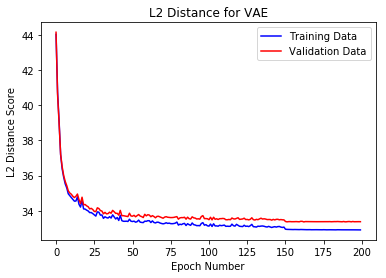

In [17]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_recon_scores, 'b', range(n_epochs), val_recon_scores, 'r')
plt.title('L2 Distance for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('L2 Distance Score')
plt.show()

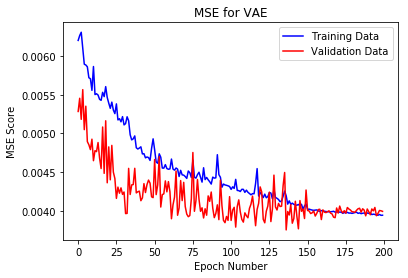

In [18]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_r2_scores, 'b', range(n_epochs), val_r2_scores, 'r')
plt.title('MSE for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('MSE Score')
plt.show()

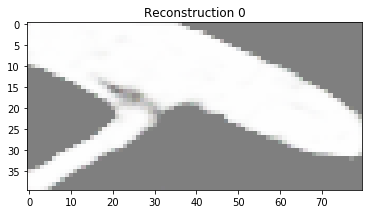

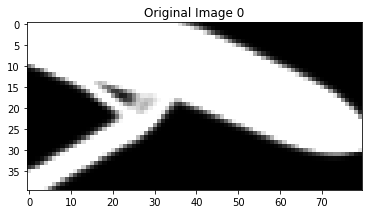

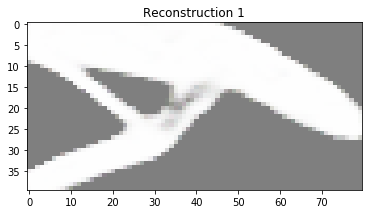

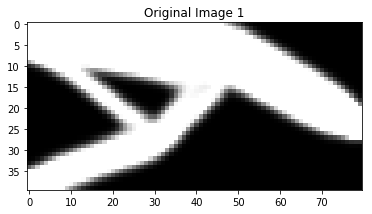

In [19]:
# Show examples of the ground truth image and the reconstruction after
# a pass through the autoencoder
def get_example_outputs(model, data_loader):
    model.eval()
    ground_truth = []
    model_output = []
    with torch.no_grad():
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, var, reg = model(image)
            model_output.append(recon)
            ground_truth.append(image)
            if len(model_output) == 2:
                return model_output, ground_truth
            
model_out, gt = get_example_outputs(model, val_loader)
for idx in range(2):
    plt.figure()
    plt.title("Reconstruction " + str(idx))
    model_out[idx] = model_out[idx].view(model_out[idx].shape[1], model_out[idx].shape[2], model_out[idx].shape[3])
    plt.imshow(model_out[idx].permute([1, 2, 0]).cpu().numpy())
    plt.figure()
    plt.title("Original Image " + str(idx))
    gt[idx] = gt[idx].view(gt[idx].shape[1], gt[idx].shape[2], gt[idx].shape[3])
    plt.imshow(gt[idx].permute([1, 2, 0]).cpu().numpy())

In [20]:
test_recon_score, test_mse_score = get_score_model(best_model, test_loader)
print('Test L2 Score: ' + str(test_recon_score))
print('Test MSE Score: ' + str(test_mse_score))

Test L2 Score: 33.334793
Test MSE Score: 0.004784675
